# 1. Exploración inicial

In [2]:
import numpy as np
import pandas as pd

In [3]:
df_drugs = pd.read_excel("./src/data/data_drugs.xlsx", header = 2)
df_drugs.head()

,Country,Country code,Survey year,Prevalence (%),Substance,Recall period,Age,Sample size,Males (%),Females (%)
0,Austria,AT,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650,24.8,20.6
1,Austria,AT,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712,26.8,27.6
2,Austria,AT,2020,6.3,Cannabis,Last year,Adults (15-64),4650,6.8,5.8
3,Austria,AT,2020,11.1,Cannabis,Last year,Young adults (15-34),1712,10.7,11.4
4,Austria,AT,2020,3.6,Cannabis,Last month,Adults (15-64),4650,4,3.1


In [4]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         1043 non-null   object 
 1   Country code    1043 non-null   object 
 2   Survey year     1043 non-null   int64  
 3   Prevalence (%)  1043 non-null   float64
 4   Substance       1043 non-null   object 
 5   Recall period   1043 non-null   object 
 6   Age             1043 non-null   object 
 7   Sample size     1043 non-null   object 
 8   Males (%)       1043 non-null   object 
 9   Females (%)     1043 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 81.6+ KB


In [5]:
df_drugs.nunique()

Country            29
Country code       29
Survey year        12
Prevalence (%)    358
Substance           7
Recall period       3
Age                 2
Sample size        77
Males (%)         378
Females (%)       334
dtype: int64

## 1.1. Observaciones
Country code lo podemos eliminar, ya que significa lo mismo que Country.

Survey year es entero, y tengo datos de 12 años distintos, buena progresión.

Prevalence es float.

Recall period indica el periodo de tiempo de consumo. Lifetime es alguna vez en la vida, last year en el último año y last month en el último mes.

Age indica dos ventanas de edad, de 15-34 y de 15-64, lo que no entiendo es porqué el segundo tramo no empieza en 35 directamente. Están los datos acumulados?

Sample size indica el total de personas encuestadas. Que deberíamos pasar a numérico.

Males y females son porcentajes de hombres y mujeres, que también pasaremos a numérico.

## 1.2. Definición de hipótesis iniciales

🔹 Hipótesis 1: Existen diferencias significativas en la prevalencia del consumo de determinadas drogas entre países europeos.


🔹 Hipótesis 2: La prevalencia del consumo varía de forma notable según el recall period, siendo mayor en medidas de consumo a lo largo de la vida que en periodos recientes.


🔹 Hipótesis 3: Las diferencias de consumo entre hombres y mujeres varían según la sustancia analizada.


🔹 Hipótesis 4: Algunas sustancias muestran patrones de consumo más homogéneos entre países que otras.


# 2. Limpieza de datos

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# comienzo unificando los nombres de las columnas para evitar problemas
df_drugs.columns = (df_drugs.columns.str.lower().str.replace(" ", "_"))

## 2.1. Tratamiento de faltantes

In [8]:
df_drugs.isna().sum()

country           0
country_code      0
survey_year       0
prevalence_(%)    0
substance         0
recall_period     0
age               0
sample_size       0
males_(%)         0
females_(%)       0
dtype: int64

En la revisión inicial de dataframe he visto huecos, pero isna no los detecta porque no son NA. Vamos a corregir los tipos de datos primero y volvemos a revisar.

## 2.2. Conversión de tipo de dato

In [9]:
df_drugs.dtypes

country            object
country_code       object
survey_year         int64
prevalence_(%)    float64
substance          object
recall_period      object
age                object
sample_size        object
males_(%)          object
females_(%)        object
dtype: object

In [10]:
cols_to_numeric = ["sample_size", "males_(%)", "females_(%)"]

for col in cols_to_numeric:
    df_drugs[col] = pd.to_numeric(df_drugs[col], errors="coerce")


In [11]:
df_drugs[cols_to_numeric].isna().sum()


sample_size    93
males_(%)      26
females_(%)    42
dtype: int64

Retomamos el tratamiento de faltantes por los nuevos NA que han aparecido con los cambios de tipo, que coinciden con los huecos vacíos.

Decisión:
No considero sensato imputar ninguna de las tres columnas, ni eliminar los datos ni imputarlo a la media, ya que no tiene sentido. No quiero perder las filas porque tengo datos válidos de ese país en prevalence, así que voy a manejar el dataframe con los faltantes y usaré un filtro sin NA cuando lo necesite.

In [12]:
df_sample = df_drugs.dropna(subset=["sample_size"])
df_sex = df_drugs.dropna(subset=["males_(%)", "females_(%)"])
df_sin_na = df_drugs.dropna()

## 2.3. Identificación y gestión de duplicados 

In [13]:
df_drugs.duplicated().sum()

np.int64(0)

No existen duplicados así que no se ha realizado ninguna acción. 

## 2.4. Detección y manejo de outliers

In [14]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%)
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803
std,2.174479,26.759251,4568.853108,28.697494,25.437743
min,2008.000000,0.000000,442.000000,0.000000,0.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000


In [15]:
Q1 = df_drugs["prevalence_(%)"].quantile(0.25)
Q3 = df_drugs["prevalence_(%)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(np.float64(-37.724999999999994), np.float64(64.475))

In [16]:
outliers = df_drugs[
    (df_drugs["prevalence_(%)"] < lower_bound) |
    (df_drugs["prevalence_(%)"] > upper_bound)
]

outliers.shape

(114, 10)

In [17]:
outliers.head()

,country,country_code,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%)
30,Austria,AT,2020,94.9,Alcohol,Lifetime,Adults (15-64),4650.0,95.4,94.3
31,Austria,AT,2020,90.1,Alcohol,Lifetime,Young adults (15-34),1712.0,89.7,90.4
32,Austria,AT,2020,85.3,Alcohol,Last year,Adults (15-64),4650.0,86.2,84.4
33,Austria,AT,2020,76.8,Alcohol,Last year,Young adults (15-34),1712.0,76.4,77.2
34,Austria,AT,2020,77.2,Alcohol,Last month,Adults (15-64),4650.0,79.8,74.5


<Axes: >

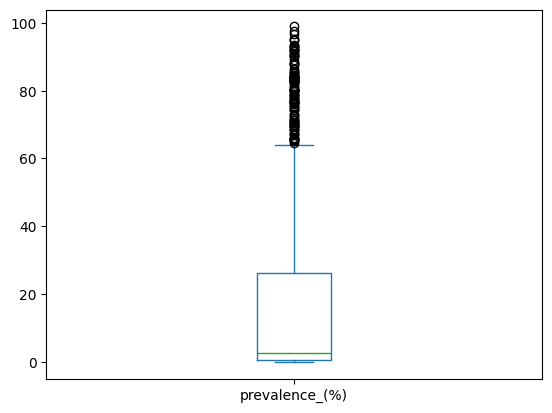

In [18]:
df_drugs["prevalence_(%)"].plot(kind="box")


Dado que los valores extremos detectados mediante el análisis descriptivo pueden reflejar diferencias reales entre países, sustancias(sobre todo por el alcohol que está más normalizado) o periodos de recuerdo, se ha optado por conservarlos en el conjunto de datos y analizarlos de forma contextualizada en etapas posteriores del proyecto.

## 2.5. Eliminación de columnas innecesarias

In [19]:
df_drugs = df_drugs.drop(columns=["country_code"])

## 2.6. Estandarización o normalización si aplica
En nuestro caso no aplica

## 2.7. Creación de nuevas variables
Voy a crear una nueva variable que indique la desigualdad entre sexos en una sola variable, así facilita las comparaciones entre países, años o sustancias


In [20]:
df_drugs["gender_gap"] = (df_drugs["males_(%)"] - df_drugs["females_(%)"])


## 2.8. Guardado de datos

In [21]:
df_drugs.to_csv("./src/data/data_clean/drugs.csv")
df_drugs_no_na = df_drugs.dropna()
df_drugs_no_na.to_csv("./src/data/data_clean/drugs_no_na.csv")

# 3. EDA ANÁLISIS UNIVARIANTE

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from IPython.display import display
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
import itertools
import os


In [23]:
from src.utils.funciones import (cardinalidad, pinta_distribucion_categoricas, columnas_numericas, plot_multiple_boxplots,
                            plot_histo_dens, plot_combined_graphs, plot_categorical_relationship_fin, 
                            grafico_dispersion_con_correlacion, guardar_figura)


In [24]:
df_drugs = pd.read_csv("./src/data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("./src/data/data_clean/drugs_no_na.csv", index_col=0)

## 3.1. Distribución del sexo

In [25]:
df_drugs[["males_(%)", "females_(%)"]].describe()

,males_(%),females_(%)
count,1017.000000,1001.000000
mean,19.904621,15.596803
std,28.697494,25.437743
min,0.000000,0.000000
25%,0.800000,0.300000
50%,3.900000,1.800000
75%,32.000000,21.300000
max,99.600000,98.200000


El análisis univariante del consumo de estupefacientes según el sexo evidencia una mayor prevalencia de consumo en hombres respecto a mujeres. En el conjunto del dataset, la prevalencia media de consumo en hombres alcanza el 19,9 %, mientras que en mujeres se sitúa en torno al 15,6 %.
Esta diferencia se mantiene al analizar la mediana de la distribución, con valores del 3,9 % en hombres y del 1,8 % en mujeres, lo que sugiere que la brecha de género no se limita a valores extremos, sino que está presente en el conjunto de la distribución. Asimismo, la amplitud de los valores observados indica una elevada variabilidad en los niveles de consumo.

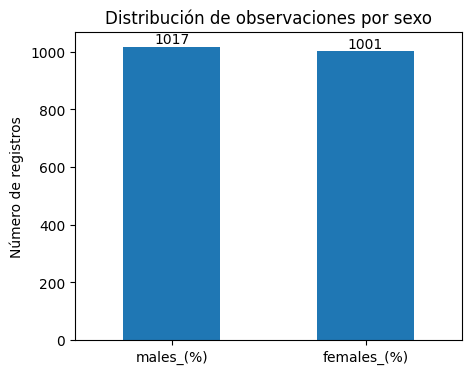

In [27]:
plt.figure(figsize=(5, 4))

frecuencia_sexo = df_drugs[["males_(%)", "females_(%)"]].notna().sum()
ax = frecuencia_sexo.plot(kind="bar")

plt.title("Distribución de observaciones por sexo")
plt.ylabel("Número de registros")
plt.xticks(rotation=0)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

plt.savefig(
    "src/img/analisis_univariante/01_frecuencia_por_sexo.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


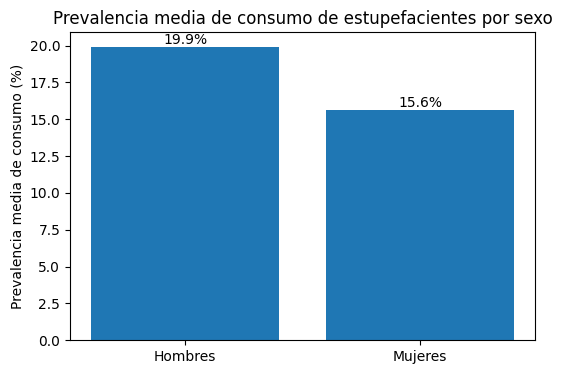

In [46]:
# Calcular la prevalencia media por sexo
mean_males = df_drugs['males_(%)'].mean()
mean_females = df_drugs['females_(%)'].mean()

# Datos para el gráfico
sex = ['Hombres', 'Mujeres']
prevalence = [mean_males, mean_females]

# Crear el gráfico
plt.figure(figsize=(6, 4))
bars = plt.bar(sex, prevalence)
plt.ylabel('Prevalencia media de consumo (%)')
plt.title('Prevalencia media de consumo de estupefacientes por sexo')

# Añadir etiquetas encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

# Guardar y mostrar
plt.savefig(
    'src/img/analisis_univariante/01_prevalencia_consumo_por_sexo.png',
    bbox_inches='tight'
)
plt.show()
plt.close()

## 3.2. Distribución de la edad

In [28]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

El análisis de la variable edad muestra que el conjunto de datos distingue únicamente entre dos grupos de edad, siendo el grupo Adults (15–64) el más representado en el dataset, con 528 registros, frente al resto de grupos de edad. Esta distribución refleja una mayor disponibilidad de información para la población adulta, lo que debe tenerse en cuenta a la hora de interpretar los resultados relacionados con el consumo.

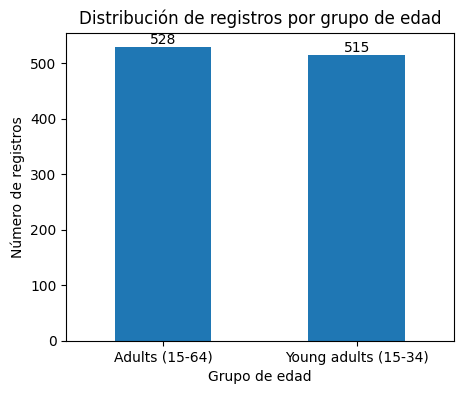

In [29]:
plt.figure(figsize=(5, 4))

frecuencia_edad = df_drugs["age"].value_counts()
ax = frecuencia_edad.plot(kind="bar")

plt.title("Distribución de registros por grupo de edad")
plt.ylabel("Número de registros")
plt.xlabel("Grupo de edad")
plt.xticks(rotation=0)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

plt.savefig(
    "src/img/analisis_univariante/02_frecuencia_por_edad.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



## 3.3. Distribución de los países

In [30]:
df_drugs["country"].describe()

count        1043
unique         29
top       Austria
freq           42
Name: country, dtype: object

El análisis de la variable país muestra que el conjunto de datos incluye información de 29 países europeos, con una distribución desigual del número de registros por país. Austria es el país con mayor representación en el dataset, con 42 observaciones, mientras que otros países presentan una menor frecuencia de registros. Esta heterogeneidad en la representación debe tenerse en cuenta al analizar y comparar los niveles de consumo entre países.

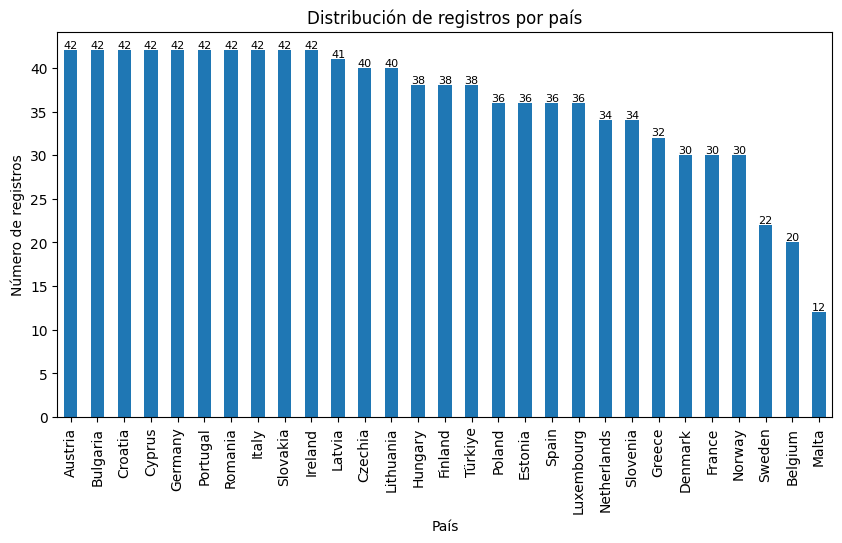

In [31]:
plt.figure(figsize=(10, 5))

frecuencia_pais = df_drugs["country"].value_counts()
ax = frecuencia_pais.plot(kind="bar")

plt.title("Distribución de registros por país")
plt.ylabel("Número de registros")
plt.xlabel("País")
plt.xticks(rotation=90)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.savefig(
    "src/img/analisis_univariante/03_frecuencia_por_pais.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## 3.2. Distribución del tipo de sustancia

In [32]:
df_drugs["substance"].describe()

count         1043
unique           7
top       Cannabis
freq           171
Name: substance, dtype: object

El análisis univariante por tipo de sustancia muestra que el cannabis es la sustancia con mayor número de registros en el conjunto de datos, seguido de cocaína y éxtasis, lo que indica una representación relativamente equilibrada entre varias sustancias ilegales.

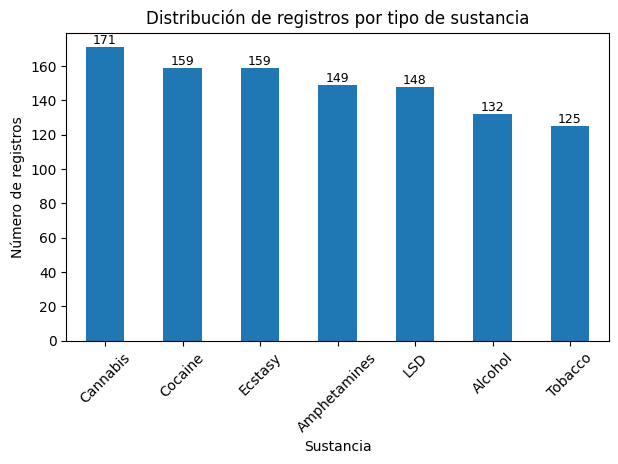

In [33]:
plt.figure(figsize=(7, 4))

frecuencia_sustancia = df_drugs["substance"].value_counts()
ax = frecuencia_sustancia.plot(kind="bar")

plt.title("Distribución de registros por tipo de sustancia")
plt.ylabel("Número de registros")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)

# 👉 Añadir los valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.savefig(
    "src/img/analisis_univariante/04_frecuencia_por_sustancia.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


### Conclusión análisis univariante
De forma preliminar, los resultados del análisis univariante sugieren la existencia de diferencias en los patrones de consumo tanto según el sexo como según el país. No obstante, estas observaciones descriptivas deben interpretarse con cautela, ya que no consideran de manera conjunta las posibles interacciones entre variables. Por este motivo, se procede a continuación a un análisis bivariante que permita evaluar las hipótesis planteadas de forma más precisa.

# 4. EDA ANÁLISIS BIVARIANTE

## 4.1. Sustancias según sexo

In [48]:
df_drugs.groupby("substance")["males_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,78.879845,15.780998,13.8,73.10,83.00,87.80,99.6
Amphetamines,145.0,2.236552,2.797117,0.0,0.40,1.10,2.70,12.0
Cannabis,166.0,16.225904,13.880948,1.0,5.75,11.05,23.85,60.4
Cocaine,155.0,2.928387,3.370301,0.0,0.60,1.60,3.65,17.4
Ecstasy,155.0,2.794839,3.828427,0.0,0.45,1.30,3.70,24.2
LSD,145.0,1.250345,1.665213,0.0,0.10,0.50,1.80,8.7
Tobacco,122.0,49.027049,15.038969,4.5,40.90,48.15,57.60,86.8


En primer lugar y, respecto el consumo masculino por tipo de sustancia, los resultados arrojan diferencias notables respecto dicho consumo por sustancia:

* El alcohol tiene el mayor nivel de consumo en hombres, con una media cercana al 79% y una mediana superior al 83%, indicando un consumo muy extendido

* El tabaco también muestra valores elevados, con una media aproximada del 49% y una dispersión moderada, reflejando una prevalencia elevada, aunque con más variabilidad que el alcohol.

* El cannabis presenta una posición intermedia, con una media de consumo masculino de aproximadamente el 16%, pero con una desviación estándar elevada, hecho que indica una heterogeneidad destacable

* Sustancias como Cocaína, Éxtasis, Anfetaminas y LSD tienen niveles de consumo masculino considerablemente más bajos, con medianas generalmente por debajo del 2%, aunque con ciertos valores extremos que elevan la media.


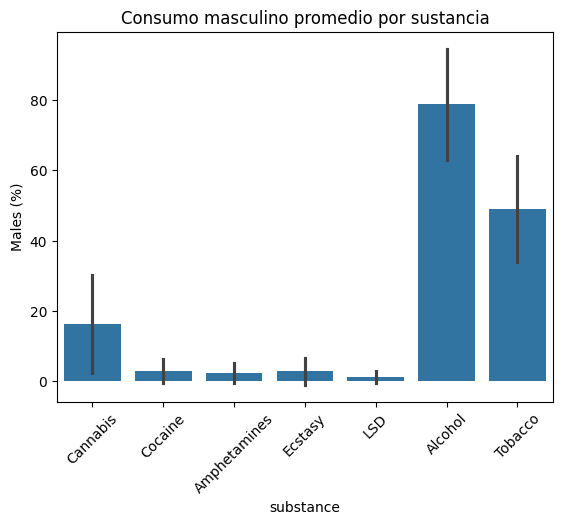

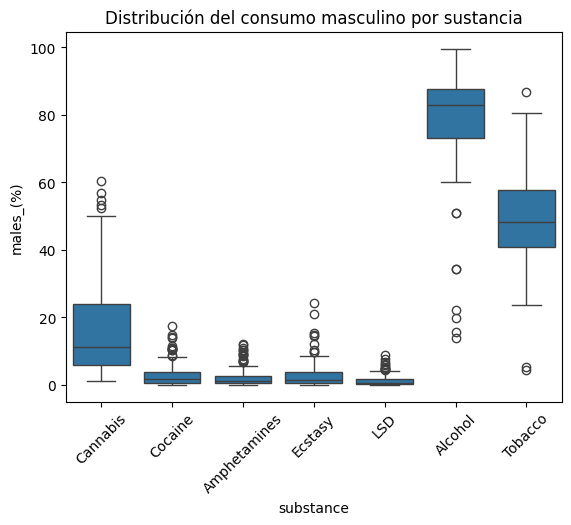

In [50]:
sns.barplot(data=df_drugs, x="substance", y="males_(%)", errorbar='sd')
plt.title("Consumo masculino promedio por sustancia")
plt.ylabel("Males (%)")
plt.xticks(rotation=45)
plt.savefig("src/img/analisis_bivariante/01_promedio_sustancias_hombres.png",dpi=300,bbox_inches="tight")
plt.show()

sns.boxplot(data=df_drugs, x="substance", y="males_(%)")
plt.title("Distribución del consumo masculino por sustancia")
plt.xticks(rotation=45)
plt.savefig("src/img/analisis_bivariante/01_distribucion_sustancias_hombres.png",dpi=300,bbox_inches="tight")
plt.show()

In [51]:
df_drugs.groupby("substance")["females_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,68.759690,20.472777,3.7,60.300,74.80,82.500,98.2
Amphetamines,143.0,1.090909,1.469066,0.0,0.100,0.50,1.350,7.1
Cannabis,166.0,9.627108,10.679300,0.0,2.125,5.25,13.375,48.8
Cocaine,151.0,1.435099,1.806477,0.0,0.250,0.80,1.750,8.1
Ecstasy,151.0,1.468874,2.288353,0.0,0.200,0.60,1.850,15.4
LSD,139.0,0.533094,0.744194,0.0,0.000,0.20,0.650,4.0
Tobacco,122.0,36.686066,14.695681,6.0,24.850,34.30,46.275,72.4


Respecto el **consumo femenino por tipo de sustancia**, se aprecia que sigue un patrón similar al de los hombres a pesar de que muestra niveles sistemáticamente más bajos:

* El alcohol sigue siendo la sustancia más consumida por las mujeres, con una media cercana al 69% que, aunque es inferior a la masculina, sigue siendo elevada.
* El tabaco presenta una media aproximada del 37%, de nuevo notablemente inferior a la observada en hombres.
* El cannabis tiene una media cercana al 10%, con alta variabilidad
* El consumo femenino de Cocaína, Éxtasis, Anfetaminas y LSD es bajo, con medianas generalmente inferiores al 1%, y menor dispersión que en el consumo masculino.

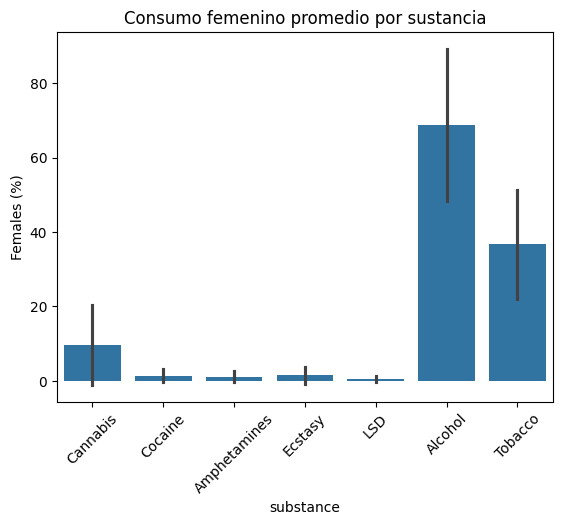

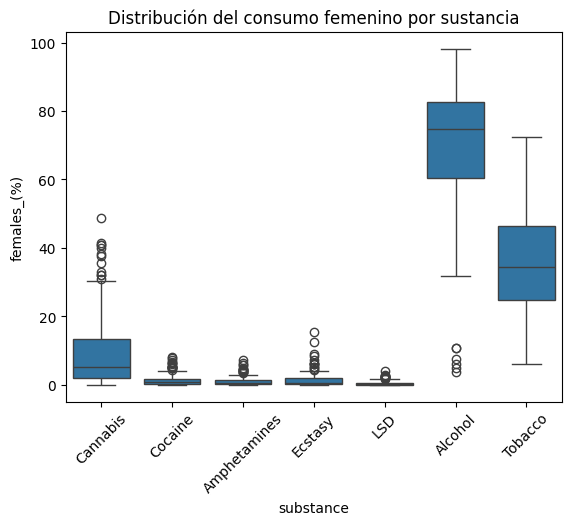

In [54]:
sns.barplot(data=df_drugs, x="substance", y="females_(%)", errorbar='sd')
plt.title("Consumo femenino promedio por sustancia")
plt.ylabel("Females (%)")
plt.xticks(rotation=45)
plt.savefig("src/img/analisis_bivariante/01_promedio_sustancias_mujeres.png",dpi=300,bbox_inches="tight")
plt.show()

sns.boxplot(data=df_drugs, x="substance", y="females_(%)")
plt.title("Distribución del consumo femenino por sustancia")
plt.xticks(rotation=45)
plt.savefig("src/img/analisis_bivariante/01_distribucion_sustancias_mujeres.png",dpi=300,bbox_inches="tight")
plt.show()

Paralelamente, es necesario realizar una comparación entre las mujeres y los hombres:

* Para todas las sustancias que se han analizado, el consumo masculino es superior al femenino
* Las mayores diferencias se observan en el Alcohol, el Tabaco y el Cannabis, que, a su vez, son las que tienen los mayores niveles de consumo en los dos sexos
* En sustancias con baja prevalencia, como el LSD, las diferencias existen pero son menos pronunciadas como consecuencia de los bajos niveles generales de consumo.

En conclusión, este análisis ha mostrado que el consumo es mayor en hombres que en mujeres para todas las sustancias. Además, la elevada dispersión en algunas sustancias sugiere la influencia de factores adicionales como el país, que serán explorados en análisis posteriores.

## 4.2. Sustancias por países

In [64]:
df_drugs.groupby("country")["prevalence_(%)"].describe().head()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,21.233333,30.311808,0.0,1.000,5.15,29.225,94.9
Belgium,20.0,19.955000,25.236116,0.0,1.350,7.55,28.975,82.1
Bulgaria,42.0,19.542857,28.781499,0.0,0.400,2.05,49.250,82.2
Croatia,42.0,22.857143,30.133428,0.0,1.475,5.20,43.375,92.8
Cyprus,42.0,18.745238,28.023233,0.1,0.300,1.50,38.500,83.5


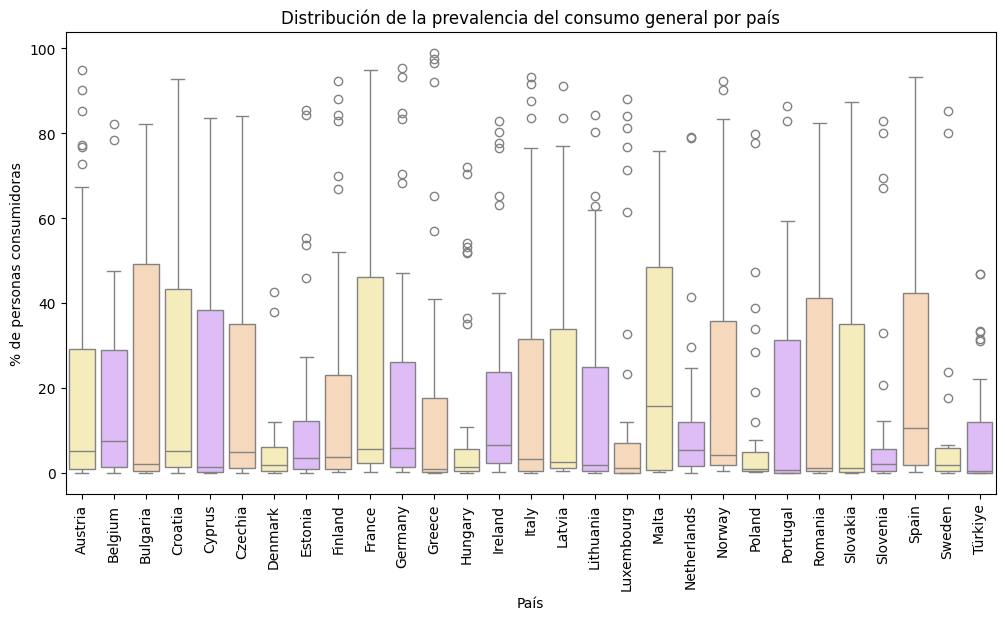

In [65]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country',
    y='prevalence_(%)',
    hue='country',
    data=df_drugs,
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución de la prevalencia del consumo general por país')
plt.ylabel('% de personas consumidoras')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.savefig("src/img/analisis_bivariante/02_consumo_por_países.png",dpi=300,bbox_inches="tight")

plt.show()

In [58]:
df_drugs.groupby("country")["males_(%)"].describe().head()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,21.716667,30.428508,0.1,1.200,6.10,30.525,95.4
Belgium,20.0,22.825000,26.300748,0.0,2.125,11.30,33.750,85.0
Bulgaria,42.0,20.861905,31.062604,0.0,0.400,1.70,50.775,88.5
Croatia,42.0,25.240476,31.120459,0.1,2.100,7.55,46.100,94.1
Cyprus,42.0,22.580952,31.904126,0.1,0.425,2.50,50.550,87.8


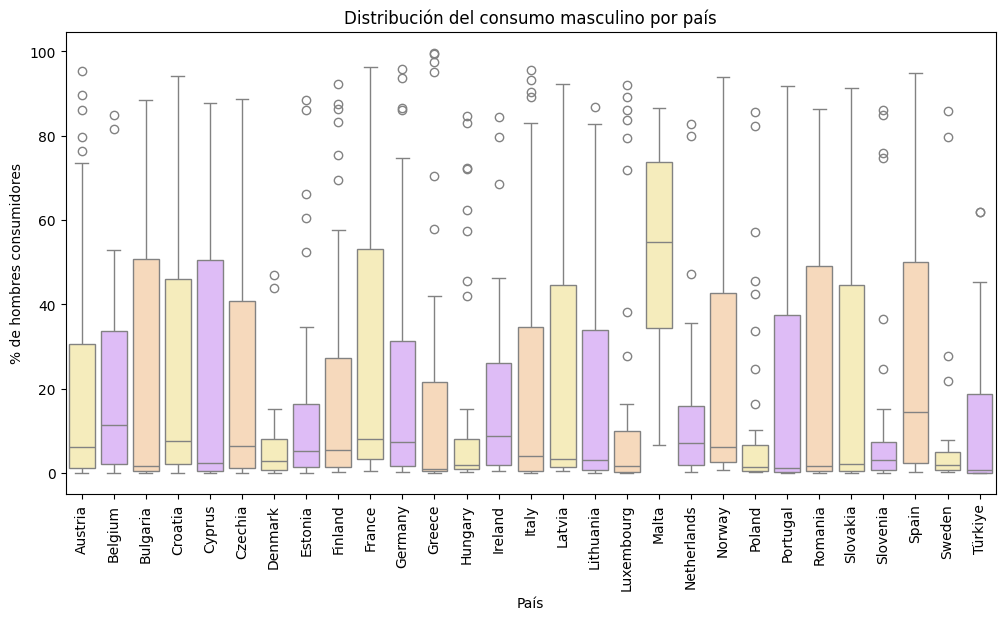

In [62]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country',
    y='males_(%)',
    hue='country', 
    data=df_drugs,
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución del consumo masculino por país')
plt.ylabel('% de hombres consumidores')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.savefig("src/img/analisis_bivariante/02_consumo_masculino_países.png",dpi=300,bbox_inches="tight")

plt.show()

In [61]:
df_drugs.groupby("country")["females_(%)"].describe().head()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,20.723810,30.216219,0.0,0.725,4.10,28.050,94.3
Belgium,20.0,17.175000,24.377381,0.0,0.500,3.85,24.725,79.4
Bulgaria,42.0,18.304762,26.690338,0.0,0.400,1.75,47.175,76.4
Croatia,42.0,20.428571,29.227654,0.0,0.800,2.80,40.650,92.1
Cyprus,42.0,15.030952,24.598369,0.0,0.100,0.50,27.175,79.2


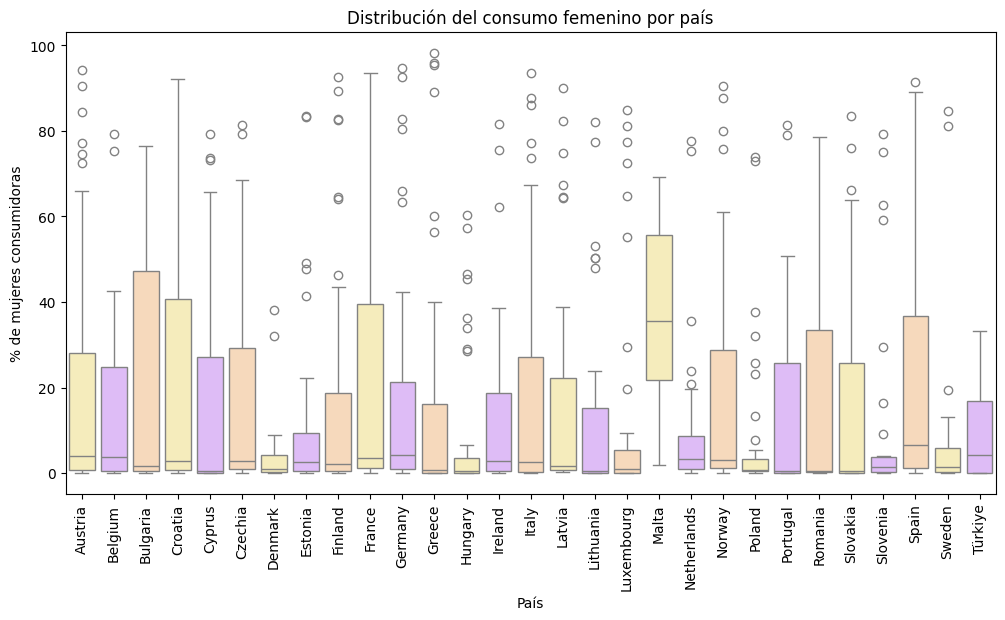

In [63]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country', 
    y='females_(%)', 
    hue='country',
    data=df_drugs, 
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución del consumo femenino por país')
plt.ylabel('% de mujeres consumidoras')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.savefig("src/img/analisis_bivariante/02_consumo_femenino_paises.png",dpi=300,bbox_inches="tight")

plt.show()

El análisis del consumo masculino revelaría diferencias estadísticamente significativas entre países europeos. Concretamente, Malta destaca con el promedio más alto de consumo masculino (aproximadamente 52%), por encima del resto de países. Francia y Esopaña también tienen promedios relativamente altos (alrededor del 29–28%), mientras que países como Países Bajos o Polonia muestran los valores más bajos (alrededor del 12–14%).

Igual que en el caso femenino, muchos estados presentan alta variabilidad. Italia, Croacia y Austria muestran desviaciones estándar cercanas a 30%, con valores mínimos muy bajos y máximos que superan el 90%. Esto indicaría que, a pesar de que el promedio nacional puede ser moderado, existen subgrupos con niveles de consumo muy diferentes dentro del mismo país. Otros países, como Malta, mostrarían menor dispersión relativa, reflejando datos más concentrados alrededor de sus promedios.

En conjunto, estos resultados indican que existen diferencias claras en la prevalencia masculina de consumo entre países europeos

# 5. EDA ANÁLISIS MULTIVARIANTE

## 5.1. Consumo por sustancia y por edad

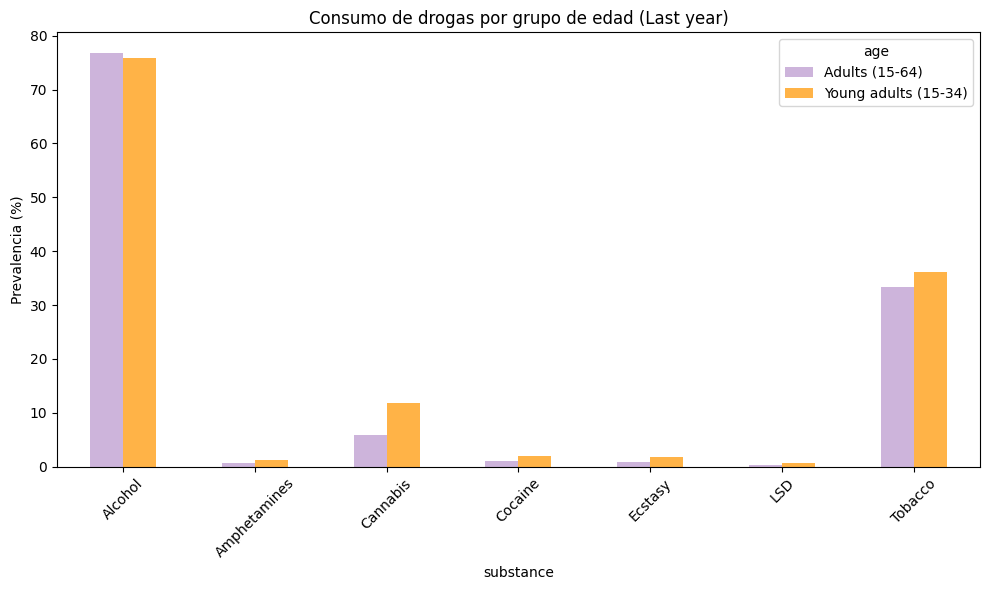

In [67]:
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="substance",
    columns="age",
    aggfunc="mean"
)

pivot_age[["Adults (15-64)", "Young adults (15-34)"]].plot(
    kind="bar",
    figsize=(10, 6),
    color=["#CDB4DB", "#FFB347"]
)

plt.ylabel("Prevalencia (%)")
plt.title("Consumo de drogas por grupo de edad (Last year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("src/img/analisis_multivariante/01_consumo_sustancias_edad.png",dpi=300,bbox_inches="tight")

plt.show()

Esta gráfica representa la prevalencia media de consumo en el último año entre adultos y jóvenes para cada sustancia.

* El alcohol y el tabaco presentan valores elevados y similares en ambos grupos (consumo ampliamente extendido)
* El cannabis destaca por mostrar una prevalencia mucho mayor en jóvenes adultos
* En el resto de sustancias, aunque los niveles de consumo son bajos, se aprecia de forma consistente un mayor consumo entre jóvenes, lo que sugiere una mayor experimentación en edades tempranas.

# 5.2. Consumo por sexo y edad

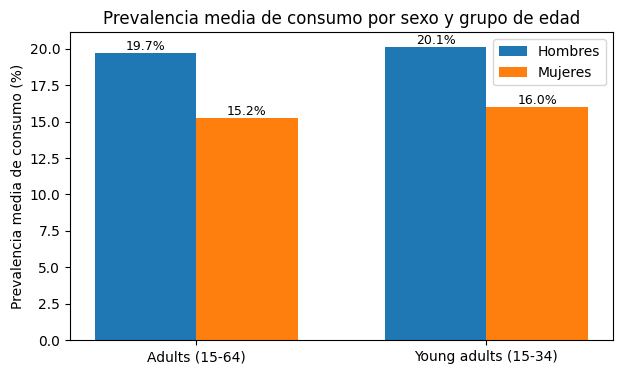

In [68]:
# Calcular prevalencia media por sexo y edad
grouped = df_drugs.groupby('age')[['males_(%)', 'females_(%)']].mean()

ages = grouped.index
male_values = grouped['males_(%)']
female_values = grouped['females_(%)']

x = np.arange(len(ages))
width = 0.35

plt.figure(figsize=(7, 4))
bars1 = plt.bar(x - width/2, male_values, width, label='Hombres')
bars2 = plt.bar(x + width/2, female_values, width, label='Mujeres')

plt.ylabel('Prevalencia media de consumo (%)')
plt.title('Prevalencia media de consumo por sexo y grupo de edad')
plt.xticks(x, ages)
plt.legend()

# Etiquetas encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.savefig(
    'src/img/analisis_multivariante/02_sexo_edad_prevalencia.png',
    bbox_inches='tight'
)
plt.show()
plt.close()


## 5.3. Consumo por sustancia, sexo y edad

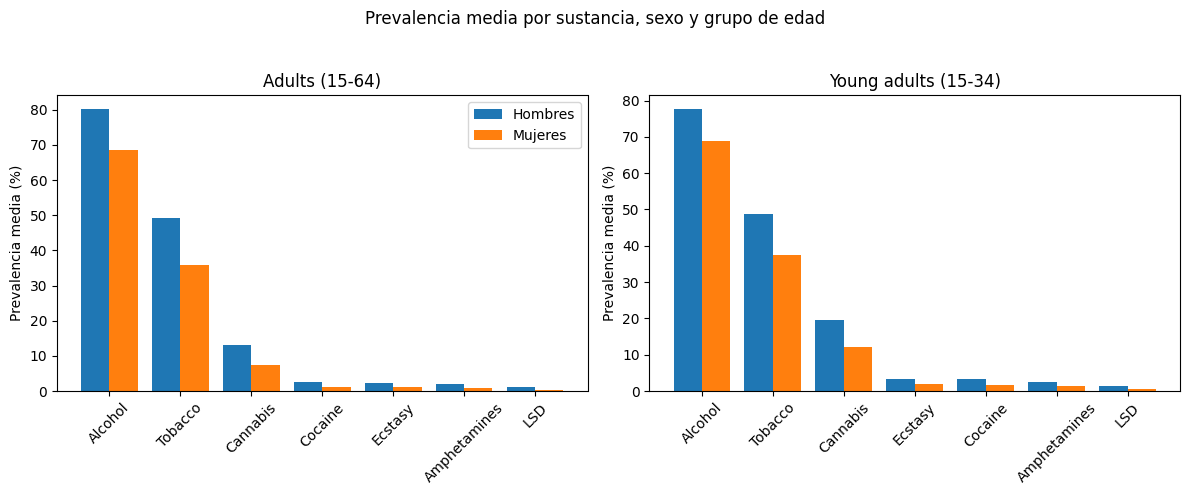

In [69]:

# Obtener grupos de edad
age_groups = df_drugs['age'].unique()

plt.figure(figsize=(12, 5))

for i, age_group in enumerate(age_groups, 1):
    subset = df_drugs[df_drugs['age'] == age_group]
    
    substance_means = (
        subset
        .groupby('substance')[['males_(%)', 'females_(%)']]
        .mean()
        .sort_values(by='males_(%)', ascending=False)
    )
    
    x = range(len(substance_means))
    
    plt.subplot(1, len(age_groups), i)
    bars1 = plt.bar(
        [p - 0.2 for p in x],
        substance_means['males_(%)'],
        width=0.4,
        label='Hombres'
    )
    bars2 = plt.bar(
        [p + 0.2 for p in x],
        substance_means['females_(%)'],
        width=0.4,
        label='Mujeres'
    )
    
    plt.xticks(x, substance_means.index, rotation=45)
    plt.title(age_group)
    plt.ylabel('Prevalencia media (%)')
    
    if i == 1:
        plt.legend()

plt.suptitle('Prevalencia media por sustancia, sexo y grupo de edad')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(
    'src/img/analisis_multivariante/03_sustancia_sexo_edad.png',
    bbox_inches='tight'
)
plt.show()
plt.close()


## 5.4. Consumo por país, género y sustancia

In [70]:
df_gender = df_drugs.melt(
    id_vars=["country", "substance", "survey_year", "recall_period", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender["gender"] = df_gender["gender"].str.replace("_(%)", "", regex=False)
df_gender["prevalence"] = pd.to_numeric(df_gender["prevalence"], errors="coerce")

df_gender.head()

pivot_gender = df_gender.pivot_table(
    values="prevalence",
    index="country",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender.head()

substance    Alcohol            Amphetamines             Cannabis             \
gender       females      males      females     males    females      males   
country                                                                        
Austria    81.083333  82.733333     1.633333  2.700000  12.450000  13.416667   
Belgium    77.400000  83.300000     0.200000  1.100000  10.216667  19.316667   
Bulgaria   64.883333  78.766667     1.516667  1.616667   6.316667   6.450000   
Croatia    77.500000  85.166667     1.816667  4.666667  12.550000  22.733333   
Cyprus     66.483333  82.400000     0.033333  0.383333   4.666667  13.866667   

substance   Cocaine             Ecstasy                 LSD            \
gender      females     males   females     males   females     males   
country                                                                 
Austria    2.616667  3.583333  2.133333  2.783333  0.616667  0.666667   
Belgium    0.800000  3.450000  0.800000  2.900000  0.050000  0.000000   
Bulgaria   1.300000  1.450000  1.000000  0.700000  0.166667  0.116667   
Croatia    1.783333  5.033333  1.283333  3.933333  0.516667  1.000000   
Cyprus     0.350000  1.866667  0.266667  1.133333  0.033333  0.650000   

substance    Tobacco             
gender       females      males  
country                          
Austria    44.533333  46.133333  
Belgium    30.925000  39.775000  
Bulgaria   52.950000  56.933333  
Croatia    47.550000  54.150000  
Cyprus     33.383333  57.766667

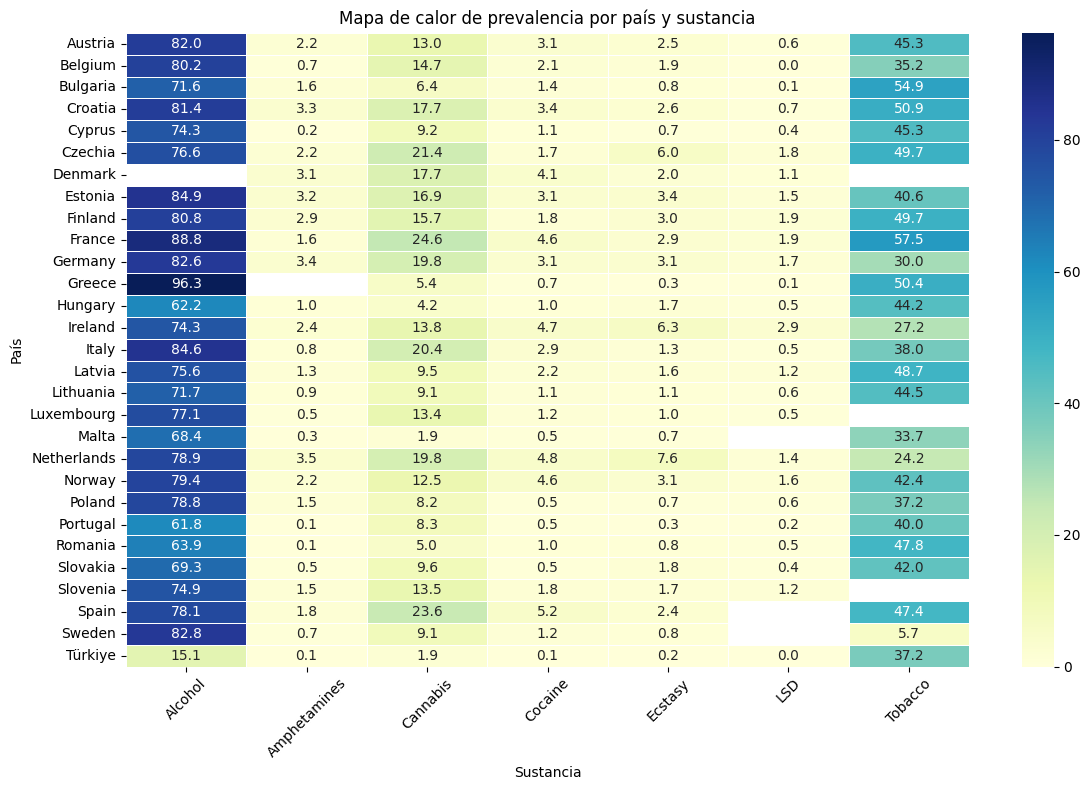

In [71]:
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance",
    aggfunc="mean"
)
plt.figure(figsize=(12,8))
sns.heatmap(
    pivot,
    annot=True,        
    fmt=".1f",        
    cmap="YlGnBu",    
    linewidths=0.5 
)
plt.title("Mapa de calor de prevalencia por país y sustancia")
plt.ylabel("País")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(
    'src/img/analisis_multivariante/04_consumo_sustancia_pais.png',
    bbox_inches='tight'
)
plt.show()